In [5]:
# !pip3 install pyro-ppl
# !pip3 install sklearn
# !pip3 install arviz
# !pip3 install numpy
# !pip3 install matplotlib

In [1]:
import pyro
import torch
import pyro.distributions as pdist
import torch.distributions as tdist
import arviz
import numpy as np
import matplotlib.pyplot as plt 
from torch.distributions import constraints

/opt/conda_env/jmj/miniconda3/envs/pyro_env3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Exercise 1

Given unnormalized density: $p(x) = exp(\frac{-x^2}{2})(\sin(x)^2 + 3\cos(x)^2\sin(7x)^2 + 1)$ for $x \in [-3,3]$, the task is to sample from this distribution and calulcate $E[x^2]$ using the Pyro PPL. 

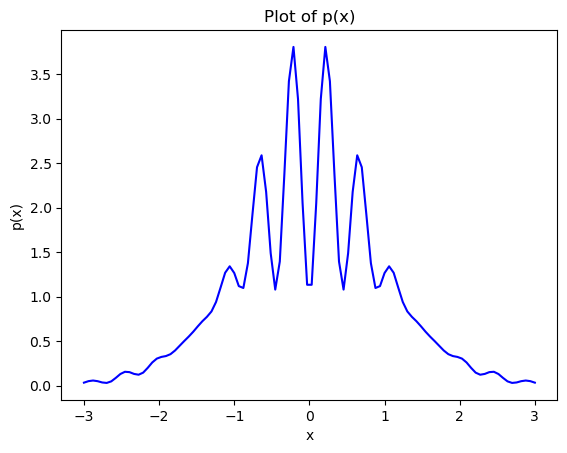

In [2]:
# visualization of the unnormalized density p(x) #

def p(x):
    return np.exp(-x**2 / 2) * (np.sin(x)**2 + 3 * np.cos(x)**2 * np.sin(7 * x)**2 + 1)

x = np.linspace(-3, 3, 100)

plt.plot(x, p(x), color='blue')
plt.xlabel('x')
plt.ylabel('p(x)')
plt.title('Plot of p(x)')
plt.show()

1. Calculate it using Pyro's NUTS (sampler) (with warm-up and number of chains >1). Use ArviZ for diagnostics. 

We have our density p(x) and our integration interval, so now we our building our custom density function with this information as below in the MyDensity class object. 

In [3]:
class MyDensity(pdist.TorchDistribution):
    # The integration interval
    support = constraints.interval(-3.0, 3.0)
    # Constraint for the starting value used in the sampling
    # (should be within integration interval)
    arg_constraints = {"start": support}  

    def __init__(self, start=torch.tensor(0.0)): 
        # start = starting value for HMC sampling, default 0
        self.start = start 
        batch_shape = torch.Size()
        super(MyDensity, self).__init__(batch_shape=batch_shape, event_shape=torch.Size())

    def sample(self, sample_shape=torch.Size()):
        # This is only used to start the HMC sampling
        # It simply returns the starting value for the sampling
        return self.start 
    
    def log_prob(self, x):
        # Return log of the (unnormalized) density
        
        # Mask values outside [-3, 3] with -inf
        out_of_bounds = (x < -3.0) | (x > 3.0)
        log_density = (-x**2 / 2) + torch.log((torch.sin(x)**2 + 3 * torch.cos(x)**2 * torch.sin(7 * x)**2 + 1))
        
        # Return log density with masked invalid values
        return log_density.masked_fill(out_of_bounds, float("-inf"))

In [4]:
# Specify the model, which in our case is just our MyDensity distribution

def model():
    # sample x uniformly within [-3, 3]
    x = pyro.sample("x", pyro.distributions.Uniform(-3.0, 3.0))
    # Evaluate the custom density with MyDensity
    sample = pyro.sample("sample", MyDensity(x))
    return sample

In [6]:
# Run HMC / NUTS

num_samples = 20
nuts_kernel = pyro.infer.NUTS(model, jit_compile=True)
mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=num_samples, num_chains=2, warmup_steps=100)
mcmc.run()

Sample [2]: 100%|██████████| 120/120 [00:02, 51.93it/s, step size=1.09e-01, acc. prob=0.954]


In [7]:
# get the samples from the MCMC object

samples = mcmc.get_samples()["x"]

# calculate E[x**2]
E_x2 = torch.mean(samples**2).item()
print(f"Estimated E[x^2]: {E_x2}")

Estimated E[x^2]: 1.5419591665267944


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sample -0.266  0.856  -1.255    2.015      0.402    0.305       4.0      41.0   
x       0.013  1.258  -1.746    2.183      0.222    0.158      32.0      50.0   

        r_hat  
sample   2.20  
x        1.03  


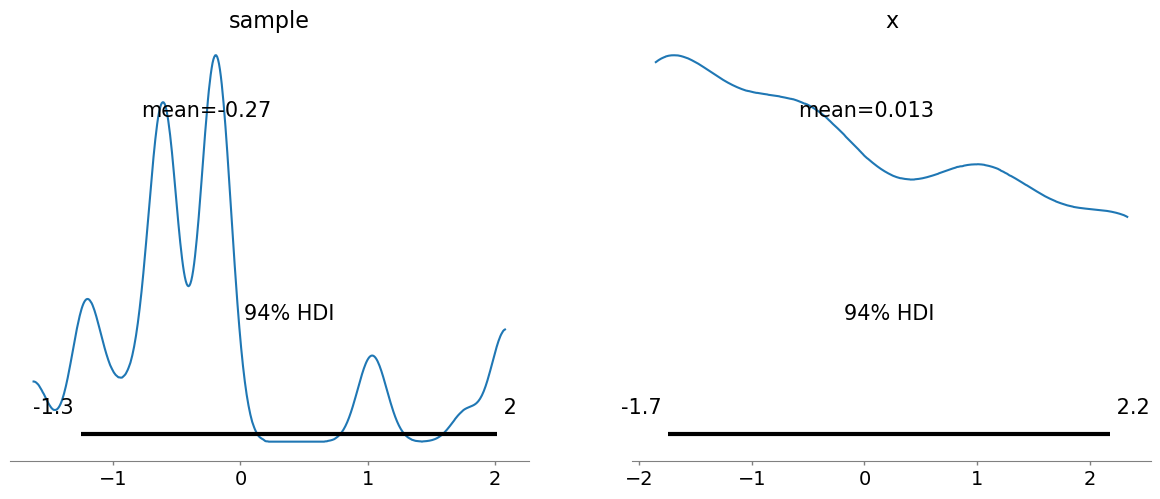

In [8]:
# use arviz to summarize and investigate: plot
data = arviz.from_pyro(mcmc)

# ESS, r-hat
summary = arviz.summary(data)
print(summary)
# Density plot
arviz.plot_posterior(data)
plt.show()

2. Repeat the previous sampling method with Pyro for sample sizes: {10, 100, 1000}. For each sample size, calculate the mean and standard deviation of the estimator $E[x^2]$, e.g. by repeating each simulation an appropriate number of times . Plot the values. Compare to the methods from last week. Which method appears to perform better?

In [5]:
# HMC / NUTS
def HMC(n_samples):
    # Run HMC / NUTS
    nuts_kernel = pyro.infer.NUTS(model, jit_compile=False)
    mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=n_samples, num_chains=2, warmup_steps=100)
    mcmc.run()
    
    # send to arviz
    data = arviz.from_pyro(mcmc)

    # Get the samples
    samples = mcmc.get_samples()["x"]

    # Calculate E(x^2)
    expected_val = torch.mean(samples**2).item()
    return expected_val, data

Sample [2]: 100%|██████████| 110/110 [00:02, 40.84it/s, step size=1.30e-01, acc. prob=0.781]


Expectation at 10 samples: 3.971968173980713
         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sample -0.470  1.406  -1.528    2.452      0.475    0.348      11.0      26.0   
x       0.409  2.001  -2.451    2.893      0.392    0.361      26.0      22.0   

        r_hat  
sample   1.28  
x        0.95  


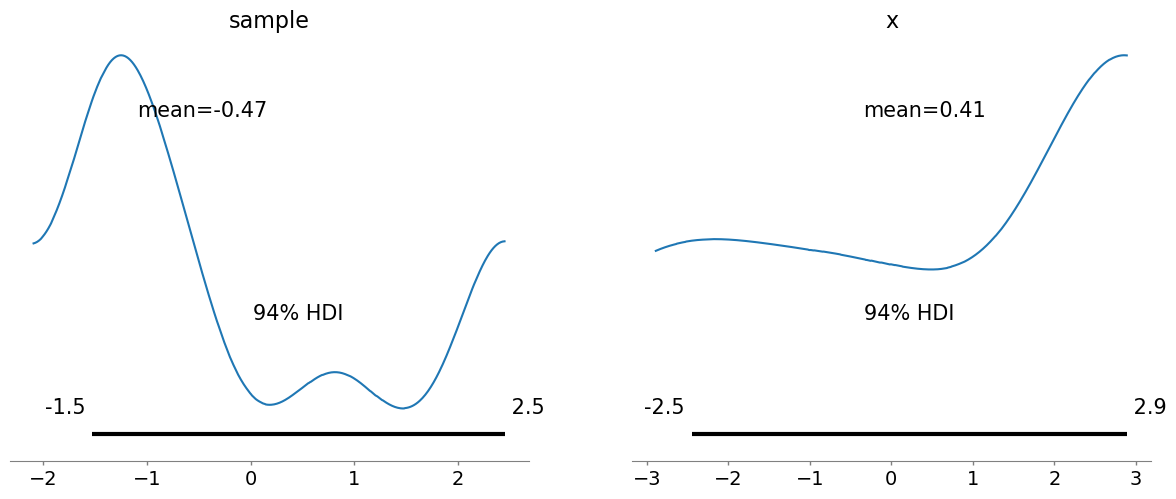

In [ ]:
for n_samples in [10,100,1000]: 
    E_x2, data = HMC(n_samples)
    print(f'Expectation at {n_samples} samples: {E_x2}')
    
    # ESS, r-hat
    summary = arviz.summary(data)
    print(summary)
    # Density plot
    ax, _ = arviz.plot_posterior(data)
    ax.set_xlim(-3, 3)
    plt.show()

Sample [2]: 100%|██████████| 110/110 [00:03, 35.16it/s, step size=9.61e-02, acc. prob=0.967]


Expectation at 10 samples: 1.4008333683013916
         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sample -0.287  1.078  -1.777    0.984      0.264    0.191      16.0      22.0   
x      -0.383  1.149  -2.135    1.566      0.292    0.210      14.0      22.0   

        r_hat  
sample   1.03  
x        1.07  


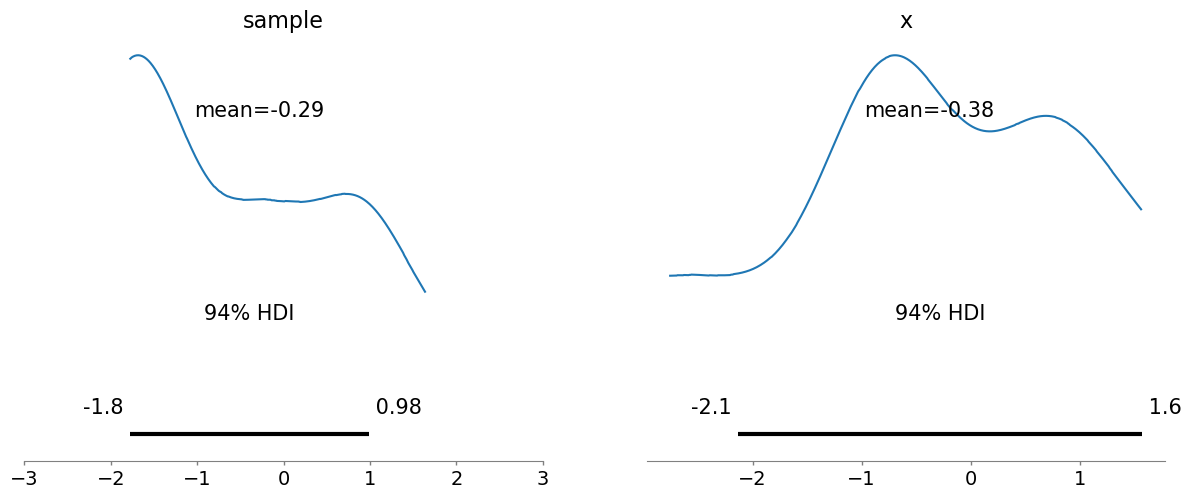

In [5]:
n_samples = 10
 
E_x2, data = HMC(n_samples)
print(f'Expectation at {n_samples} samples: {E_x2}')

# ESS, r-hat
summary = arviz.summary(data)
print(summary)
# Density plot
ax, _ = arviz.plot_posterior(data)
ax.set_xlim(-3, 3)
plt.show()

Warmup [2]:   0%|          | 0/200 [00:00, ?it/s]8it/s, step size=1.12e-01, acc. prob=0.905]


Expectation at 100 samples: 3.171156644821167
         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sample  0.195  0.949  -1.548    2.051      0.122    0.086      62.0      79.0   
x      -0.077  1.784  -2.990    2.680      0.427    0.307      16.0      26.0   

        r_hat  
sample   1.04  
x        1.12  


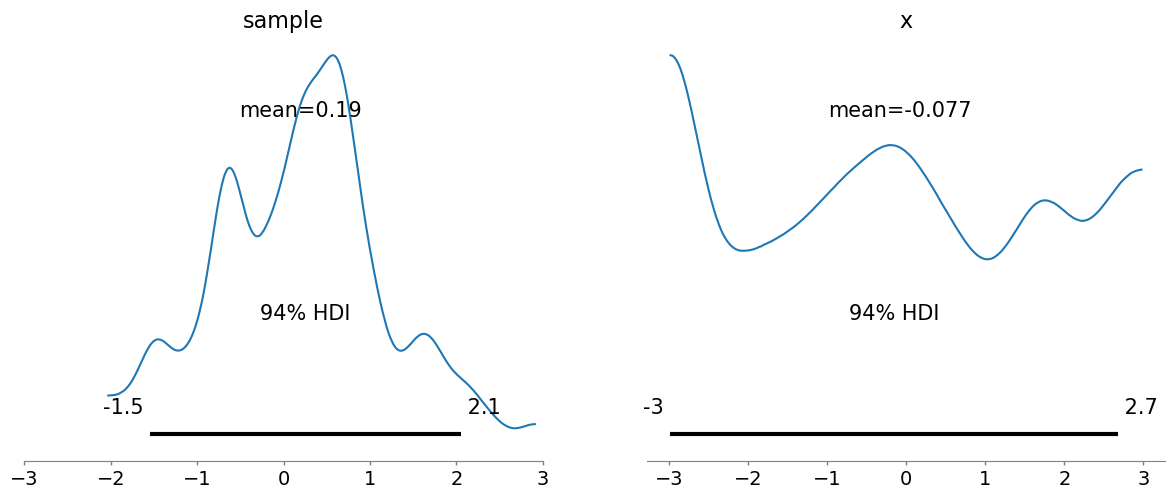

In [6]:
n_samples = 100
 
E_x2, data = HMC(n_samples)
print(f'Expectation at {n_samples} samples: {E_x2}')

# ESS, r-hat
summary = arviz.summary(data)
print(summary)
# Density plot
ax, _ = arviz.plot_posterior(data)
ax.set_xlim(-3, 3)
plt.show()

Sample [2]: 100%|██████████| 1100/1100 [00:17, 64.68it/s, step size=2.17e-01, acc. prob=0.687]


Expectation at 1000 samples: 3.021263599395752
         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sample  0.028  0.969  -1.868    1.826      0.048    0.034     407.0     606.0   
x      -0.012  1.739  -2.627    2.951      0.071    0.061     611.0     562.0   

        r_hat  
sample   1.01  
x        1.00  


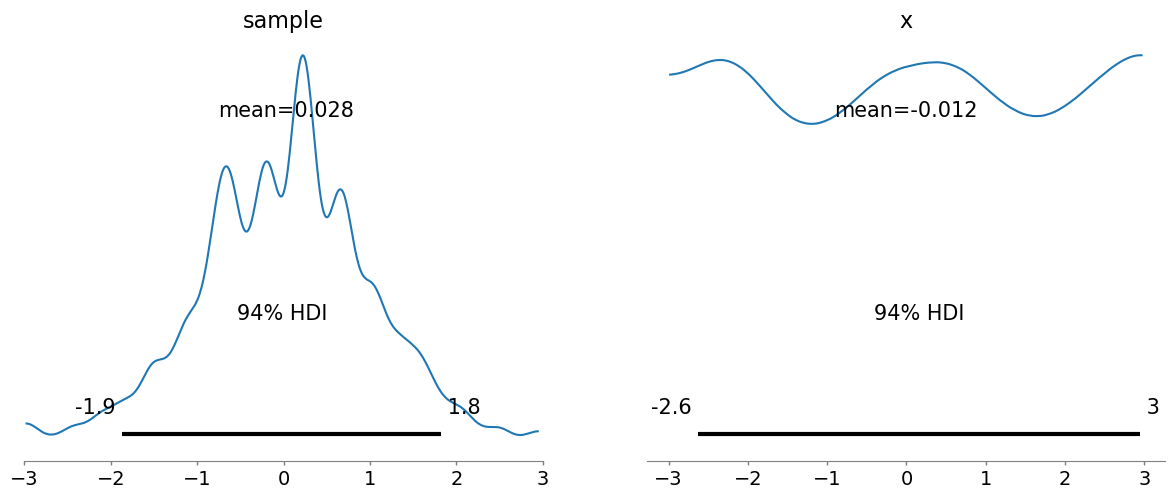

In [6]:
n_samples = 1000
 
E_x2, data = HMC(n_samples)
print(f'Expectation at {n_samples} samples: {E_x2}')

# ESS, r-hat
summary = arviz.summary(data)
print(summary)
# Density plot
ax, _ = arviz.plot_posterior(data)
ax.set_xlim(-3, 3)
plt.show()